# Paper Notes

## Out-of-sample extension of graph adjacency spectral embedding, Levin

### Out-of-sample problem description. 

Working with embeddings where you have some training set $D = \{z_1, z_2, ..., z_n\}$ and you want to embed each each training sample in a lower dimensional ($d$) space. Let $X \epsilon R^{n\times d}$ be that embeding where the nth row corresponds to the embedding of $z_n$. The out of sample problem is to embed a z you havent seen using only $X$

### Laplacian Embedding

Laplacian embedding is a graph embedding. Given Adjacency matrix $A \epsilon R^{n \times n}$. Laplacian $L = D^{-1/2}AD^{-1/2}$. Note, $D \epsilon R^{n \times n}$ where $d_{ii} = \sum_j A_{ij}$. The embedding is given by the rows of $U_L \epsilon R^{n \times d}$ whose columns are the d orthonormal eigenvectors corresponding to the top d eigenvalues of L (not including 1). 

### Out of sample extension

In order to get the out of sample extension we do the following:

$min_{f(x)\epsilon R^d} \sum_{i=1}^n{(K(x, x_i) - \frac{1}{n}\sum_{t=1}{d}{\lambda_t f_t(x_i) f_t(x)})}$

Note: 
$f_t(x_i) = (v_t)_i$ which is the ith component of $v_t$

### Question, is Laplacian Spectral Embedding the same as Laplacian eigenmaps embedding?

## Laplacian Eigenmaps and Spectral Techniques for Embedding and Clustering, Belkin

#### The laplacian eigenmap embedding has a property where it conserves locality. This means that it emphasizes natural spatial clusters in the data. 

### LSE algorithm: 
![](spectral_clustering_alg.png)
![](spectral_clustering_alg_2.png)



In [1]:
!ls

Laplacian Eigenmaps and Sp ectral Techniques for Emb edding and Clustering.pdf
Laplacian Eigenmaps for Dimensionality Reduction and Data Representation.pdf
Out-of-Sample Extensions for LLE, Isomap, MDS, Eigenmaps, and Spectral Clustering.pdf
Out-of-sample extension of graph adjacency spectral embedding.pdf
Paper Notes.ipynb
figure_to_reproduce.png
spectral_clustering_alg.png
spectral_clustering_alg_2.png


# Proposed experiment to make sure it works
Replicate figure 1 in [paper](https://arxiv.org/pdf/1802.06307.pdf) from Levin

![](figure_to_reproduce.png)

How the figure was created:

1) RDPG with parameters with number of nodes 50, 100, and 500 (100 trials each)

2) Embed with the OOS LSE Algorithm 

3) Produce the plots


I could create these plots on the [OOS LSE code](https://github.com/neurodata/primitives-interfaces/tree/master/jhu_primitives/ooslse) already written, then test my implementation to ensure results are the same.


# Initial testing 

Goal: Make sure the LSE looks similar to the figure pictured above

Note: Some of the following code (namley the code for plotting) was adapted from [Alex's code](https://github.com/loftusa/graspy-personal/blob/master/oos/notebooks/paper_fig_recreation.ipynb)

In [119]:
from scipy.stats import norm
from scipy.stats import rankdata

from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

import numpy as np

from graspy.simulations import rdpg
from graspy.embed.base import BaseEmbed
from graspy.plot import heatmap, pairplot
from graspy.utils import (
    import_graph,
    is_fully_connected,
    augment_diagonal,
    pass_to_ranks,
    is_unweighted,
)

from scipy.linalg import orthogonal_procrustes

In [120]:
def _profile_likelihood_maximization(U, n_elbows):
    """
    Inputs
        U - An ordered or unordered list of eigenvalues
        n - The number of elbows to return
    Return
        elbows - A numpy array containing elbows
    """
    if type(U) == list:  # cast to array for functionality later
        U = np.array(U)

    if n_elbows == 0:  # nothing to do..
        return np.array([])

    if U.ndim == 2:
        U = np.std(U, axis=0)

    if len(U) == 0:
        return np.array([])

    elbows = []

    if len(U) == 1:
        return np.array(elbows.append(U[0]))

    # select values greater than the threshold
    U.sort()  # sort
    U = U[::-1]  # reverse array so that it is sorted in descending order
    n = len(U)

    while len(elbows) < n_elbows and len(U) > 1:
        d = 1
        sample_var = np.var(U, ddof=1)
        sample_scale = sample_var ** (1 / 2)
        elbow = 0
        likelihood_elbow = -1000000
        while d < len(U):
            mean_sig = np.mean(U[:d])
            mean_noise = np.mean(U[d:])
            sig_likelihood = 0
            noise_likelihood = 0
            for i in range(d):
                sig_likelihood += np.log(norm.pdf(U[i], mean_sig, sample_scale))
            for i in range(d, len(U)):
                noise_likelihood += np.log(norm.pdf(U[i], mean_noise, sample_scale))

            likelihood = noise_likelihood + sig_likelihood

            if likelihood > likelihood_elbow:
                likelihood_elbow = likelihood
                elbow = d
            d += 1
        if len(elbows) == 0:
            elbows.append(elbow)
        else:
            elbows.append(elbow + elbows[-1])
        U = U[elbow:]

    if len(elbows) == n_elbows:
        return np.array(elbows)

    if len(U) == 0:
        return np.array(elbows)
    else:
        elbows.append(n)
        return np.array(elbows)

In [121]:
np.random.seed(1234)

def produce(inpt, out_samp, max_dimension = 1, which_elbow = 1, n_in_sample = 1000):
    """
    Perform Out of Sample Laplacian Spectral Embedding on a graph.
    max_dimension >= 1
    which_elbow is 1 or 2
    n_in_sample >= 1
    
    """
    g = inpt.copy()

    n = g.shape[0]
    D = np.linalg.pinv(np.diag(g.sum(axis=1))**(1/2))
    L = D @ g @ D

    if max_dimension >= n:
        max_dimension = n - 1
    d_max = max_dimension

    in_sample_n = n_in_sample

    if in_sample_n > n:
        in_sample_n = n
    #print("n = ", n)
#     in_sample_idx = np.random.choice(n, in_sample_n)
    in_sample_idx = np.setdiff1d(np.arange(n), out_samp)
    #print("in_sample_idx = ", in_sample_idx)
#     out_sample_idx = np.setdiff1d(list(range(n)),in_sample_idx)
    out_sample_idx = out_samp
    #print("out_sample_idx = ", out_sample_idx)

    in_sample_A = L[np.ix_(in_sample_idx, in_sample_idx)]
    #print("in_sample_A shape = ", in_sample_A.shape)
    out_sample_A = L[np.ix_(out_sample_idx, in_sample_idx)]
    #print("out_sample_A shape = ", out_sample_A.shape)

    tsvd = TruncatedSVD(n_components = d_max)
    tsvd.fit(in_sample_A)

    eig_vectors = tsvd.components_.T
    eig_values = tsvd.singular_values_
    elbow = _profile_likelihood_maximization(eig_values, which_elbow)[-1]

    eig_vectors = eig_vectors[:, :elbow + 1].copy()
    eig_values = eig_values[:elbow + 1].copy()
    d = len(eig_values)

    in_sample_embedding = eig_vectors.dot(np.diag(eig_values**0.5))

    out_sample_embedding = out_sample_A @ eig_vectors @ np.diag(1/np.sqrt(eig_values))
    embedding = np.zeros((n,d))
    embedding[in_sample_idx] = in_sample_embedding
    embedding[out_sample_idx] = out_sample_embedding

    return embedding, in_sample_idx, out_sample_idx

In [34]:
# Needs updating... not working

def trial(n, directed=False):
    # known parameters
    labels = ["blue"]*n + ["red"]*n
    lamb = np.array([0.4, 1-.4])
    x1 = np.array([.2, .7])
    x2 = np.array([.65, .3])
    latents = np.vstack((x1, x2))
    
    # generate latent positions
    latents = np.repeat(latents, n, axis=0)

    # generate M from rdpg
    M = rdpg(latents, directed=directed)

    # index out oos
    p = np.repeat(lamb, n) / n
    i = np.random.choice(n*2, p=p)
    label = labels[i]
    a = np.delete(M[i, :], i)
    if directed:
        a2 = np.delete(M[:, i], i)
        a = (a, a2)
    A = np.delete(np.delete(M, i, 0), i, 1)
    latents_ = np.delete(latents, i, 0)

    # embed without oos stuff
    embding, insmpl, outsmpl = produce(A, max_dimension=2, n_in_sample=A.shape[0]-1)
    
    # Procrustes alignment
#     R, _ = orthogonal_procrustes(ase.latent_left_, latents_)
#     if directed:
#         R_right_, _ = orthogonal_procrustes(ase.latent_right_, latents_)

    # predict oos
    w = embding[outsmpl]
#     if not directed:
#         w = w @ R
#     else:
#         w_left_ = w[0] @ R
#         w_right_ = w[1] @ R_right_
#         w = (w_left_, w_right_)

    return w, label

# Try one trial first

In [4]:
n=50
labels = ["blue"]*n + ["red"]*n
lamb = np.array([0.4, 1-.4])
x1 = np.array([.2, .7])
x2 = np.array([.65, .3])
latents = np.vstack((x1, x2))

latents = np.repeat(latents, n, axis=0)

# generate M from rdpg
M = rdpg(latents, directed=False)

# # index out oos
# p = np.repeat(lamb, n) / n
# i = np.random.choice(n*2, p=p)
# label = labels[i]
# a = np.delete(M[i, :], i)

# #A = np.delete(np.delete(M, i, 0), i, 1)
# print(A.shape)
# latents_ = np.delete(latents, 0)

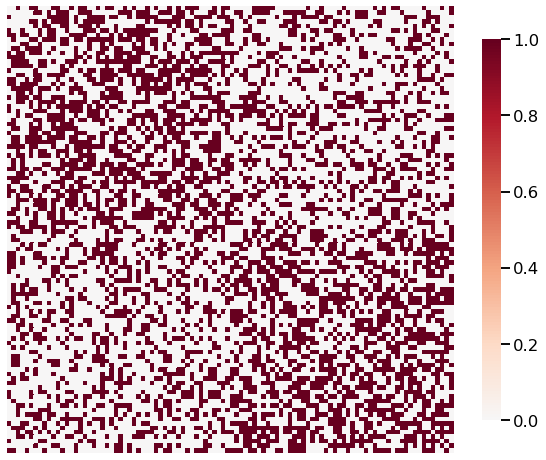

In [5]:
heatmap(M)

In [3]:
from graspy.simulations import sbm

In [4]:
from graspy.embed import LaplacianSpectralEmbed

In [89]:
n_verts = 250
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

latents = np.repeat(P, n_verts, axis=0)

undirected_sbm = sbm(2 * [n_verts], P)

309


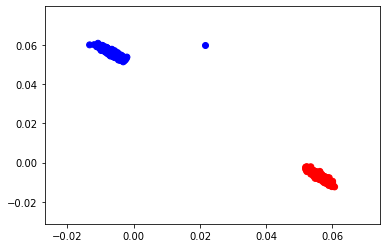

In [114]:
oos_idx = np.random.choice(n_verts*2)
print(oos_idx)
colors = np.array(["red"]*n_verts+["blue"]*n_verts)

embding, insmpl, outsmpl = produce(undirected_sbm, np.array([oos_idx]), max_dimension=2, n_in_sample=1000)

R, sca = orthogonal_procrustes(embding[insmpl], latents[insmpl])

newembed = embding[insmpl] @ R
outembed = embding[outsmpl] @ R

plt.scatter(newembed[:, 0], newembed[:, 1], color=colors[insmpl])
plt.scatter(outembed[:, 0], outembed[:, 1], color=colors[outsmpl])

In [19]:
lse = LaplacianSpectralEmbed(n_components=2)

In [20]:
Xhat = lse.fit_transform(undirected_sbm)

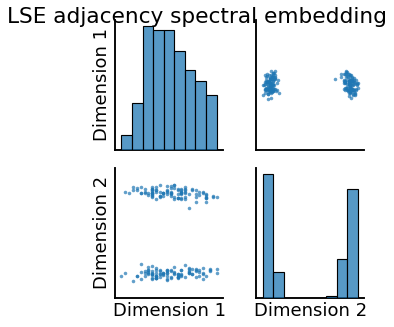

In [21]:
_ = pairplot(Xhat, title='LSE adjacency spectral embedding')

In [47]:
R, sca = orthogonal_procrustes(Xhat, latents)

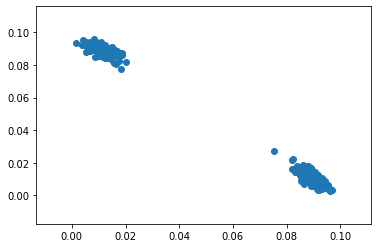

In [48]:
newembed = Xhat@R
plt.figure()
plt.scatter(newembed[:, 0], newembed[:, 1])

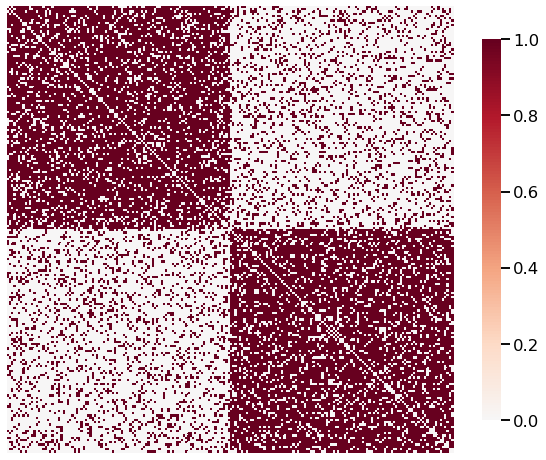

In [22]:
heatmap(undirected_sbm)

In [41]:
print(R)

[[ 0.70069433  0.7134616 ]
 [ 0.7134616  -0.70069433]]


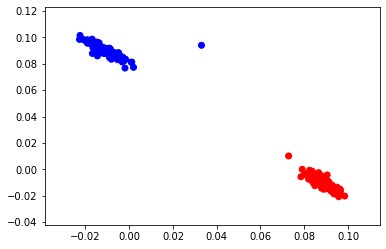

# Paper Figure Recreation

In [143]:
num_trials = 100

ptp_lst = []
col_lst = []

for nn in [26, 50, 250]:  
    points_to_plot = []
    colors = []
    print("nn=", nn)
    for ii in range(num_trials):
        n=int(nn/2)
        labels = ["blue"]*n + ["red"]*n
        
        n_verts = n
        labels_sbm = n_verts * [0] + n_verts * [1]
        P = np.array([[0.7, 0.3],
                      [0.3, 0.7]])

        latents = np.repeat(P, n, axis=0)

        undirected_sbm = sbm(2 * [n_verts], P)

        oos_idx = np.random.choice(nn)

        embding, insmpl, outsmpl = produce(undirected_sbm, np.array([oos_idx]), max_dimension=2, n_in_sample=1000)

        R, sca = orthogonal_procrustes(embding[insmpl], latents[insmpl])

        os_adj_embd = embding[outsmpl] @ R

        points_to_plot.append(os_adj_embd)
        colors.append(labels[oos_idx])

    ptp_lst.append(points_to_plot)
    col_lst.append(colors)

nn= 26
nn= 50
nn= 250


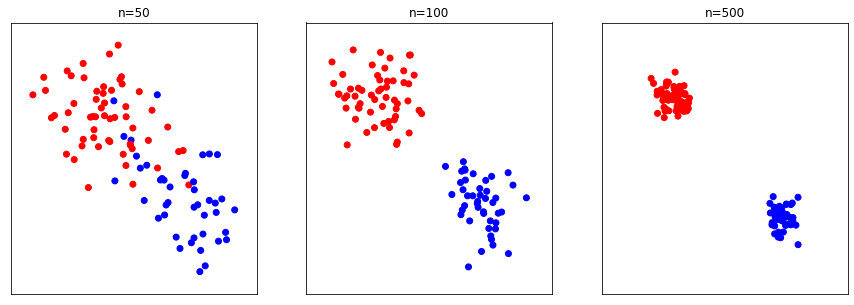

In [144]:
titles = ["n=50", "n=100", "n=500"]

plt.figure(figsize=(15, 5))
for ii, ptp in enumerate(ptp_lst):
    plt.subplot(1, 3, ii+1)
    plt.title(titles[ii])
    plt.xticks([], " ")
    plt.yticks([], " ")
    points_to_plot = np.array(ptp_lst[ii])
    plt.scatter(points_to_plot[:, 0, 0], points_to_plot[:, 0, 1], c=col_lst[ii])

In [111]:
np.random.choice(100)

42

# Recreation of Paper Figure

In [155]:
num_trials = 100

ptp_lst = []
col_lst = []

for nn in [50, 100, 500]:  
    points_to_plot = []
    colors = []
    for ii in range(num_trials):


        n=int(nn/2)
        labels = ["blue"]*n + ["red"]*n
        lamb = np.array([0.4, 1-.4])
        x1 = np.array([.2, .7])
        x2 = np.array([.65, .3])
        latents = np.vstack((x1, x2))

        latents = np.repeat(latents, n, axis=0)

        M = rdpg(latents, directed=False)

        oos_idx = np.random.choice(nn)

        embding, insmpl, outsmpl = produce(M, np.array([oos_idx]), max_dimension=2, n_in_sample=1000)

        R, sca = orthogonal_procrustes(embding[insmpl], latents[insmpl])

        os_adj_embd = embding[outsmpl] @ R

        points_to_plot.append(os_adj_embd)
        colors.append(labels[oos_idx])

    ptp_lst.append(points_to_plot)
    col_lst.append(colors)
    

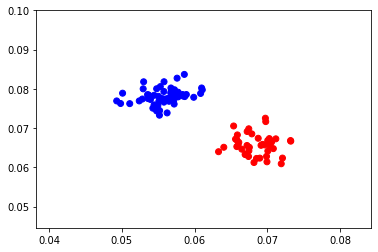

In [171]:
points_to_plot = np.array(points_to_plot)
plt.scatter(points_to_plot[:, 0, 0], points_to_plot[:, 0, 1], c=colors)

In [159]:
for ii in range(len(ptp_lst)):
    ptp_lst[ii] = np.array(ptp_lst[ii])

In [148]:
[ptp.shape for ptp in points_to_plot]

[(100, 1, 2), (100, 1, 2), (100, 1, 2)]

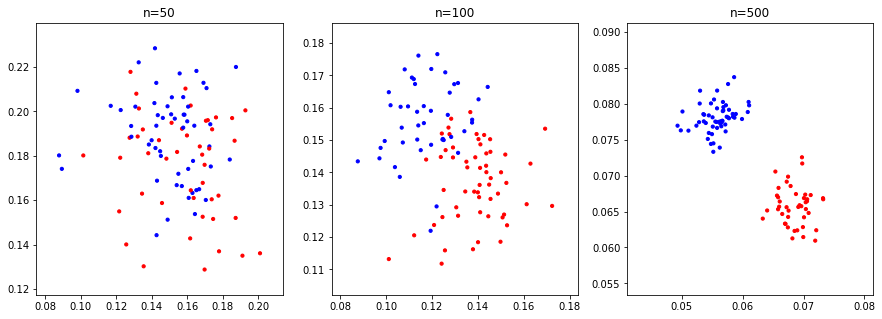

In [170]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("n=50")
plt.scatter(ptp_lst[0][:, 0, 0], ptp_lst[0][:, 0, 1], c=col_lst[0], s=10)

plt.subplot(1, 3, 2)
plt.title("n=100")
plt.scatter(ptp_lst[1][:, 0, 0], ptp_lst[1][:, 0, 1], c=col_lst[1], s=10)

plt.subplot(1, 3, 3)
plt.title("n=500")
plt.scatter(ptp_lst[2][:, 0, 0], ptp_lst[2][:, 0, 1], c=col_lst[2], s=10)

In [218]:
n=500
n=int(nn/2)
labels = ["blue"]*n + ["red"]*n
lamb = np.array([0.4, 1-.4])
x1 = np.array([.2, .7])
x2 = np.array([.65, .3])
latents = np.vstack((x1, x2))

latents = np.repeat(latents, n, axis=0)

M = rdpg(latents, directed=False)

oos_idx = np.random.choice(nn, 10)

embding, insmpl, outsmpl = produce(M, oos_idx, max_dimension=2, n_in_sample=1000)

R, sca = orthogonal_procrustes(embding[insmpl], latents[insmpl])

in_sample_idx =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  74  75  76  77  79  80  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 2

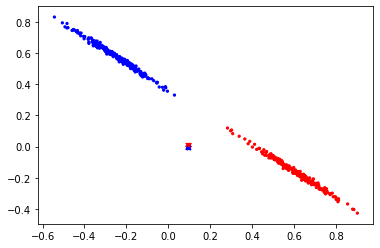

In [219]:
labels = np.array(labels)

plt.figure()
inn = embding[insmpl]
inn_colors = labels[insmpl]
out_colors = labels[outsmpl]

embding[insmpl] = (embding[insmpl] @ R)*sca
# embding[outsmpl] = embding[outsmpl] @ R


plt.scatter(embding[insmpl, 0], embding[insmpl, 1], c=labels[insmpl], marker='o', s=5)
plt.scatter(embding[outsmpl, 0], embding[outsmpl, 1], c=labels[outsmpl], marker='x', s=15)

In [190]:
len(np.where(inn_colors=='red')[0])

250

In [202]:
np.random.choice(nn, 10)

array([303, 211, 294,  53, 204, 372, 152, 143, 177, 279])

In [216]:
sca

13.153889925906824

# Modifying Graspy Code